In [1]:
import numpy as np 
import pandas as pd 
#import pydicom
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from PIL import Image
from skimage.transform import resize
from sklearn.metrics import confusion_matrix, roc_curve, auc
from efficientnet_pytorch import EfficientNet

ModuleNotFoundError: No module named 'efficientnet_pytorch'

In [2]:
# upload train dataframe
train_df_allsamples = pd.read_csv("../TrainTestDataFrames/marking.csv")
train_df_allsamples.head()

,patient_id,image_id,target,source,sex,age_approx,anatom_site_general_challenge
0,IP_7279968,ISIC_2637011,0,ISIC20,male,45.0,head/neck
1,IP_3075186,ISIC_0015719,0,ISIC20,female,45.0,upper extremity
2,IP_2842074,ISIC_0052212,0,ISIC20,female,50.0,lower extremity
3,IP_6890425,ISIC_0068279,0,ISIC20,female,45.0,head/neck
4,IP_8723313,ISIC_0074268,0,ISIC20,female,55.0,upper extremity


In [3]:
# create dictionary that maps image name to target 
image_names = train_df_allsamples["image_id"].values 
targets = train_df_allsamples["target"].values
img_to_target = {image_name:target for image_name, target in zip(image_names, targets)}

percent_tp = sum(targets)/len(targets) * 100 
print("{} training samples total.".format(len(targets)))
print("Only {:.3f} percent of training data set is a true positive.".format(percent_tp))
print("Therefore, the baseline accuracy is {:.3f}".format(np.max([percent_tp, 100-percent_tp])))

60487 training samples total.
Only 9.058 percent of training data set is a true positive.
Therefore, the baseline accuracy is 90.942


In [10]:
# update so that the number of positives balances negatives
train_df_pos = train_df_allsamples.iloc[targets>0, :]
train_df_neg = train_df_allsamples.iloc[targets==0, :]
train_df_negsample = train_df_neg.sample(n=int(train_df_pos.shape[0]))

# concatenate negative and positive samples, then shuffle using .sample() 
#train_val_df = pd.concat((train_df_pos, train_df_negsample)).sample(frac=1)
train_val_df = train_df_allsamples.sample(frac=.5)

train_val_split = .9
n_train_val = train_val_df.shape[0]
n_train = int(train_val_split*n_train_val)

train_df = train_val_df[:n_train]
val_df = train_val_df[n_train:]

# create dictionary that maps image name to target 
image_names = val_df["image_id"].values 
val_targets = val_df["target"].values

percent_tp = sum(val_targets)/len(val_targets) * 100 
baseline = np.max([percent_tp, 100-percent_tp])

print("{} Training and {} Validation samples".format(n_train, n_train_val-n_train))
print("{:.3f} percent of validation data set is a positive.".format(percent_tp))
print("Baseline validation accuracy is {:.3f}".format(baseline))

27219 Training and 3025 Validation samples
8.926 percent of validation data set is a positive.
Baseline validation accuracy is 91.074


image shape: 
(512, 512, 3)

 image is malignant?: 0


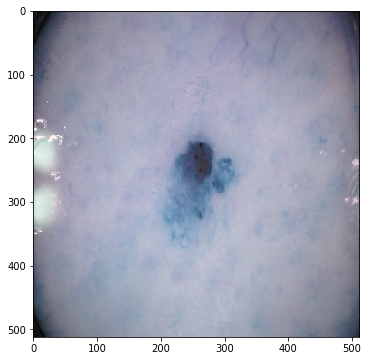

In [11]:
# start by trying to display an image from training set 

# specify path to training data  
train_path = "../../data-512/512x512-dataset-melanoma/512x512-dataset-melanoma/"

# load all training files
train_files = [s+".jpg" for s in train_df["image_id"].values]

# pull an example 
img_ind = 0
example = train_path + train_files[img_ind]
img_name = train_files[img_ind].split(".")[0]
img = plt.imread(example)
print("image shape: ")
print(img.shape)
print("\n image is malignant?: {}".format(img_to_target[img_name]))

# display 
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.show()

Need image preprocessing steps to: 

1. Isolate the melanoma and crop image 
2. Ensure cropped images are a consistent size for input to CNN 

In [6]:
# Device configuration (GPU can be enabled in settings)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cuda:0


In [7]:
meta_features = ['sex', 'age_approx', 'anatom_site_general_challenge'] 

encoder = {}
for feature in meta_features: 
    # determine unique features  
    categories = np.unique(np.array(train_df[feature].values, str))
    for i, category in enumerate(categories): 
        if category != 'nan':
            encoder[category] = np.float(i)
encoder['nan'] = np.nan

# define a unique transform each time a positive is resampled: 

# basic transform 
transform_1 = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(1.0, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

# vertical flip 
transform_2 = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(1.0, 1.0)),
    transforms.RandomVerticalFlip(1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

# horizontal flip 
transform_3 = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(1.0, 1.0)),
    transforms.RandomHorizontalFlip(1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

# vertical and horizontal flip (same as rotating 180 deg... but hopefully still useful)
transform_4 = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(1.0, 1.0)),
    transforms.RandomHorizontalFlip(1),
    transforms.RandomVerticalFlip(1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

def make_weights_for_balanced_classes(df, nclasses=2):   
    targets = df["target"].values
    count = [0] * nclasses                                                      
    for label in targets:                                                         
        count[label] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(targets)                                              
    for idx, label in enumerate(targets):                                          
        weight[idx] = weight_per_class[label]                                  
    return weight  

class ValidDataset(torch.utils.data.Dataset):
    def __init__(self, df, path_to_files):
        # 1. Initialize file paths or a list of file names.
        self.path = path_to_files
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        
        # load X 
        img_name = self.df['image_id'].values[index]
        img_path = self.path + img_name + ".jpg"
        img = plt.imread(img_path)
        
        # determine meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # load y 
        label = self.df["target"].values[index]
        target = torch.tensor(label, dtype=torch.float32)
        
        # 2. Preprocess the data (e.g. torchvision.Transform).
        img = Image.fromarray(img)
        #img = img.resize((256, 256))
        img_processed = transform_1(img)
        # 3. Return a data pair (e.g. image and label).
        return img_processed, target
        
    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]

class MyDataLoader():
    def __init__(self, df, path, batchsize):
        # store df, path, weights, ...
        self.df = df 
        self.path = path
        self.w = np.array(make_weights_for_balanced_classes(df))
        self.batchsize = batchsize 
        self.balanced = True
        
        # create a dictionary to map image_ids to index and target in dataframe 
        image_ids = self.df['image_id'].values 
        self.targets = self.df['target'].values
        inds = np.arange(len(image_ids))
        self.imgID2Idx = {im_id:ind for (im_id, ind) in zip(image_ids, inds)}
        self.imgID2Target = {im_id:target for (im_id, target) in zip(image_ids, self.targets)}
        
        # keep track of how many times samples have been drawn 
        self.counts = np.zeros(len(image_ids))
        
    def get_batch(self):
        # get image ids for the batch 
        if np.sum(self.w > 0) >= self.batchsize:
            batch_image_ids = self.df.sample(n=self.batchsize, weights=self.w)['image_id'].values
        else:
            # update batchsize 
            print("Updating batchsize, maximum dataset size reached")
            self.batchsize = np.sum(self.w > 0)
            batch_image_ids = self.df.sample(n=self.batchsize, weights=self.w)['image_id'].values
        
        # get the index locations for the image ids 
        batch_sample_inds = [self.imgID2Idx[im_id] for im_id in batch_image_ids]
        batch_targets = [self.imgID2Target[im_id] for im_id in batch_image_ids]
        
        # Update counts 
        self.counts[batch_sample_inds] += 1
        
        # Update sampling weights so that target=0 --> w = 0, target=1 --> w /= 2 
        for ind, target in zip(batch_sample_inds, batch_targets):
            # if the sample is a negative, then we don't want to sample it again 
            # if the sample has been sampled more than 3 times, it shouldn't be sampled again
            # if target is positive, sampling should happen less frequently 
            if target == 0 or self.counts[ind] > 3:
                self.w[ind] = 0 
            else:
                self.w[ind] /= 2 
        
        # Data returned in shape [Batchsize, Channels, H, W]
        images = np.zeros((self.batchsize, 3, 256, 256)) 
        labels = np.zeros(self.batchsize)
        #meta_data = np.zeros((self.batchsize, 3))
        
        for i, index in enumerate(batch_sample_inds):
            
            # 1. load image
            img_name = self.df['image_id'].values[index]
            img_path = self.path + img_name + ".jpg"
            img = plt.imread(img_path)

            # 2. Preprocess the data (e.g. torchvision.Transform).
            img = Image.fromarray(img)
            if self.counts[index] == 1:
                images[i, :, :, :] = transform_1(img)
            if self.counts[index] == 2:
                images[i, :, :, :] = transform_2(img)
            if self.counts[index] == 3:
                images[i, :, :, :] = transform_3(img)
            if self.counts[index] == 4:
                images[i, :, :, :] = transform_4(img)
                
            # 3. store label 
            labels[i] = self.imgID2Target[img_name]
                
            # 4. get meta_data 
            #meta = self.df[meta_features].values[index]
            #meta_data[i, :] = np.array([encoder[str(m)] for m in meta])
                
        # Quit once all positive samples have zero valued weights 
        if np.sum(self.w[self.targets==1]) == 0:
            self.balanced = False
        
        # return data 
        X = torch.tensor(images, dtype = torch.float32)
        y = torch.tensor(labels, dtype = torch.float32)
        return X, y #, meta_data

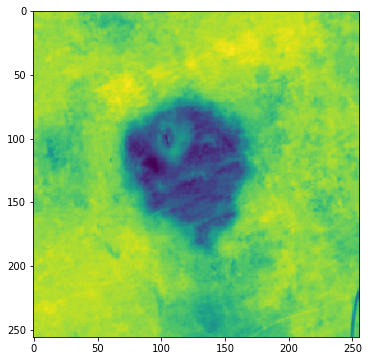

In [8]:
# Data loader (this provides queues and threads in a very simple way).
train_path = "../../data-512/512x512-dataset-melanoma/512x512-dataset-melanoma/"
custom_dataset = ValidDataset(train_df, train_path)

train_loader = torch.utils.data.DataLoader(dataset=custom_dataset,
                                           batch_size=1,
                                           shuffle=False)

data_iter = iter(train_loader)

# Mini-batch images and labels.
images, labels = data_iter.next()

# lets look at the transformed image 
im = images[0, 0, :, :].numpy()
plt.figure(figsize=(9,6))
plt.imshow(im)
plt.show()

In [9]:
# First, load the EfficientNet with pre-trained parameters 
ENet = EfficientNet.from_pretrained('efficientnet-b0').to(device)

Loaded pretrained weights for efficientnet-b0


In [10]:
# Convolutional neural network
class MyENet(nn.Module):
    def __init__(self, Net):
        super(MyENet, self).__init__()
        self.Net = Net
        self.output = nn.Sequential(
            nn.Linear(1000, 1),
            nn.Sigmoid())
        
    def embedding(self, x):
        out = self.Net(x)
        return out 
        
    def forward(self, x):
        out = self.Net(x)
        out = self.output(out)
        return out

model = MyENet(ENet).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
learning_rate = 0.001 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
def make_weights_for_balanced_classes(df, nclasses=2):   
    targets = df["target"].values
    count = [0] * nclasses                                                      
    for label in targets:                                                         
        count[label] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(targets)                                              
    for idx, label in enumerate(targets):                                          
        weight[idx] = weight_per_class[label]                                  
    return weight  

In [12]:
# Train the model
# Use the prebuilt data loader.
path = "../../data-512/512x512-dataset-melanoma/512x512-dataset-melanoma/"

# evaluate performance on validation data 
valid_dataset = ValidDataset(val_df, path)                                              
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset) 


# save losses from training 
num_epochs = 1
batchsize = 25
losses = []
val_roc = []
patience = 5
set_patience = 5 
best_val = 0

balances = []
counts = np.zeros(train_df.shape[0])

for epoch in range(num_epochs):
    i = 0
    train_loader = MyDataLoader(train_df, path, batchsize=batchsize)
    while train_loader.balanced:
        images, labels = train_loader.get_batch()
        # set up model for training 
        model = model.train()
        
        images = images.to(device)
        labels = torch.reshape(labels, [len(labels), 1])
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # store loss
        losses.append(loss)
        
        # Calculate ROC
        predictions = outputs.detach().cpu().numpy().ravel()
        targets = labels.cpu().numpy().ravel()

        fpr, tpr, _ = roc_curve(np.array(targets, np.int), np.array(predictions).ravel())
        train_roc_auc = auc(fpr, tpr)
        
        # prep model for evaluation
        valid_predictions = []
        valid_targets = []
        model.eval() 
        with torch.no_grad():
            for j, (images, labels) in enumerate(valid_loader):
                images = images.to(device)

                labels = torch.reshape(labels, [len(labels), 1])
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)

                # Calculate val ROC
                valid_predictions += list(outputs.detach().cpu().numpy().ravel())
                valid_targets += list(labels.cpu().numpy().ravel()) 

        fpr, tpr, _ = roc_curve(np.array(valid_targets, np.int), np.array(valid_predictions).ravel())
        val_roc_auc = auc(fpr, tpr)
        val_roc.append(val_roc_auc)
        
        if val_roc_auc >= best_val:
            best_val = val_roc_auc
            patience = set_patience        
            torch.save(model.state_dict(), '../Models/ENetmodel.ckpt')  
        else:
            patience -= 1
            if patience == 0:
                print('Early stopping. Best validation roc_auc: {:.3f}'.format(best_val))
                break
        i += 1
        print ('Epoch [{}/{}], Step {}, Loss: {:.4f}, Train ROC AUC: {:.4f}, Val ROC AUC: {:.4f}' 
               .format(epoch+1, num_epochs, i+1, loss.item(), train_roc_auc, val_roc_auc))
        
    if patience == 0:
        model.load_state_dict(torch.load('../Models/ENetmodel.ckpt'), strict=False)
        break

Epoch [1/1], Step 2, Loss: 0.7416, Train ROC AUC: 0.5067, Val ROC AUC: 0.6221
Epoch [1/1], Step 3, Loss: 0.8425, Train ROC AUC: 0.7193, Val ROC AUC: 0.6646
Epoch [1/1], Step 4, Loss: 0.7686, Train ROC AUC: 0.7708, Val ROC AUC: 0.6611
Epoch [1/1], Step 5, Loss: 0.4718, Train ROC AUC: 0.7986, Val ROC AUC: 0.6634
Epoch [1/1], Step 6, Loss: 0.6757, Train ROC AUC: 0.7597, Val ROC AUC: 0.6543
Epoch [1/1], Step 7, Loss: 0.6502, Train ROC AUC: 0.7756, Val ROC AUC: 0.6578
Early stopping. Best validation roc_auc: 0.665


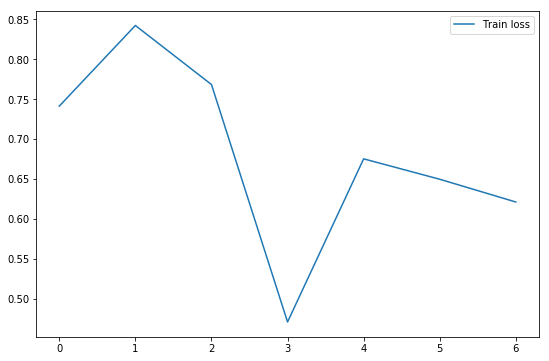

In [13]:
plt.figure(figsize=(9,6))
plt.plot(losses,label='Train loss')
#plt.ylim([.4, .8])
plt.legend()
plt.show()

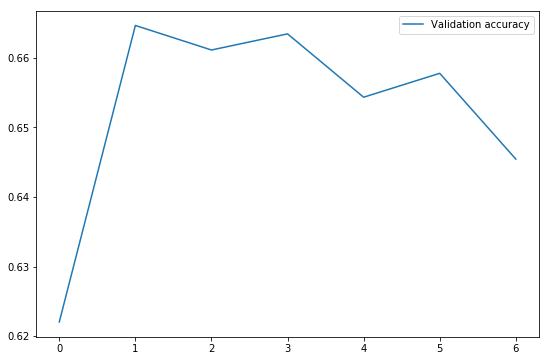

In [14]:
plt.figure(figsize=(9,6))
plt.plot(val_roc,label='Validation accuracy')
plt.legend()
plt.show()


Baseline classification accuracy: 91.31

Model classification accuracy:    71.04


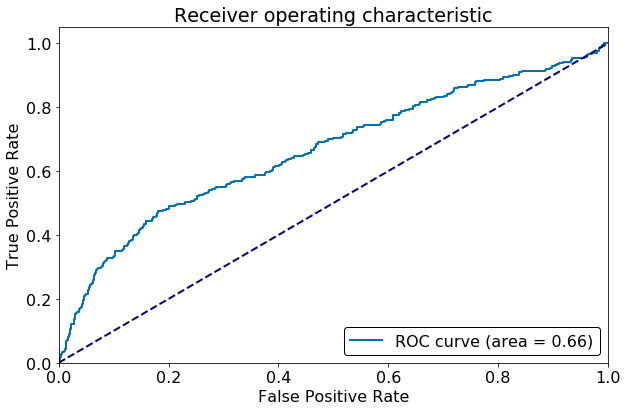

In [15]:
valid_predictions = []
valid_targets = []

model.eval() # prep model for evaluation
with torch.no_grad():
    for i, (images, labels) in enumerate(valid_loader):
        images = images.to(device)

        labels = torch.reshape(labels, [len(labels), 1])
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        valid_predictions += list(outputs.detach().cpu().numpy().ravel())
        valid_targets += list(labels.cpu().numpy().ravel()) 

fpr, tpr, _ = roc_curve(np.array(valid_targets, np.int), np.array(valid_predictions).ravel())
roc_auc = auc(fpr, tpr)

percent_tp = sum(valid_targets)/len(valid_targets) * 100 
baseline = np.max([percent_tp, 100-percent_tp])
acc = 100 * np.sum(np.round(valid_predictions) == np.array(valid_targets)) / len(valid_targets)

print('\nBaseline classification accuracy: {:.2f}'.format(baseline))
print('\nModel classification accuracy:    {:.2f}'.format(acc))

plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

lw = 2
plt.plot(fpr, tpr, 
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [16]:
confusion_matrix(np.array(valid_targets, np.int), np.round(np.array(valid_predictions).ravel()))

array([[2008,  754],
       [ 122,  141]])

In [17]:
# Save  the entire model.
train_df.to_csv("train_df.csv", index=False)
val_df.to_csv("val_df.csv", index=False)
torch.save(model.state_dict(), '../Models/ENetmodel.ckpt') 